<a href="https://colab.research.google.com/github/yaniv256/VAEs-in-Economics/blob/master/Notebooks/1d_VAE_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow.keras as keras
keras.__version__

'2.2.4-tf'

# One Dimesional Variational Auto-Encoders

This notebook contains code for the One Dimensional VAE Workshop by Yaniv Ben-Ami. The code was developed from an example found in Chapter 8, Section 4 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff) by François Chollet and the reader is invited to check that out for details.


![VAE](https://s3.amazonaws.com/book.keras.io/img/ch8/vae.png)
Source: Deep Learning with Python 

## Boston Housing


In [0]:
from tensorflow.keras import backend as K
K.clear_session()

### Data

#### Load the data

In [0]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

#### Add labels and housing price data

In [4]:
import numpy as np
import pandas as pd

labels = ['CRIM - per capita crime rate by town', 
          'ZN - proportion of residential land zoned for lots over 25,000 sq.ft.',
          'INDUS - proportion of non-retail business acres per town',
          'CHAS - Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)',
          'NOX - nitric oxides concentration (parts per 10 million)',
          'RM - average number of rooms per dwelling',
          'AGE - proportion of owner-occupied units built prior to 1940',
          'DIS - weighted distances to five Boston employment centres',
          'RAD - index of accessibility to radial highways',
          'TAX - full-value property-tax rate per $10,000',
          'PTRATIO - pupil-teacher ratio by town',
          'B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town',
          'LSTAT - % lower status of the population',
          'MEDV - Median value of owner-occupied homes in $1000\'s']

train_data = np.concatenate([train_data, train_targets.reshape((len(train_targets),1))], axis = 1)
test_data = np.concatenate([test_data, test_targets.reshape((len(test_targets),1))], axis = 1)
data = np.concatenate([train_data,test_data],axis=0)
data = pd.DataFrame(data, columns = labels)
data

,CRIM - per capita crime rate by town,"ZN - proportion of residential land zoned for lots over 25,000 sq.ft.",INDUS - proportion of non-retail business acres per town,CHAS - Charles River dummy variable (= 1 if tract bounds river; 0 otherwise),NOX - nitric oxides concentration (parts per 10 million),RM - average number of rooms per dwelling,AGE - proportion of owner-occupied units built prior to 1940,DIS - weighted distances to five Boston employment centres,RAD - index of accessibility to radial highways,"TAX - full-value property-tax rate per $10,000",PTRATIO - pupil-teacher ratio by town,B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town,LSTAT - % lower status of the population,MEDV - Median value of owner-occupied homes in $1000's
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72,15.2
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11,42.3
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26,50.0
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01,21.1
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65,17.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,3.47428,0.0,18.10,1.0,0.718,8.780,82.9,1.9047,24.0,666.0,20.2,354.55,5.29,21.9
502,0.07896,0.0,12.83,0.0,0.437,6.273,6.0,4.2515,5.0,398.0,18.7,394.92,6.78,24.1
503,1.83377,0.0,19.58,1.0,0.605,7.802,98.2,2.0407,5.0,403.0,14.7,389.61,1.92,50.0
504,0.35809,0.0,6.20,1.0,0.507,6.951,88.5,2.8617,8.0,307.0,17.4,391.70,9.71,26.7


#### Transform to percentiles

In [5]:
from sklearn.preprocessing import QuantileTransformer

qt_trans = QuantileTransformer(n_quantiles=101, random_state=2)
qt_trans.fit(train_data)
qt = pd.DataFrame(qt_trans.transform(data))
qt.columns = labels
qt

,CRIM - per capita crime rate by town,"ZN - proportion of residential land zoned for lots over 25,000 sq.ft.",INDUS - proportion of non-retail business acres per town,CHAS - Charles River dummy variable (= 1 if tract bounds river; 0 otherwise),NOX - nitric oxides concentration (parts per 10 million),RM - average number of rooms per dwelling,AGE - proportion of owner-occupied units built prior to 1940,DIS - weighted distances to five Boston employment centres,RAD - index of accessibility to radial highways,"TAX - full-value property-tax rate per $10,000",PTRATIO - pupil-teacher ratio by town,B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town,LSTAT - % lower status of the population,MEDV - Median value of owner-occupied homes in $1000's
0,0.676317,0.000,0.450000,0.0,0.510000,0.459433,0.693174,0.618406,0.280,0.425000,0.93,1.000000,0.829206,0.201216
1,0.038147,0.975,0.044131,0.0,0.078834,0.954588,0.031916,0.860000,0.070,0.526449,0.07,0.694930,0.028496,0.944661
2,0.790980,0.000,0.760000,0.0,0.750000,0.029960,1.000000,0.022964,1.000,0.865000,0.74,0.260637,0.036753,1.000000
3,0.107189,0.000,0.260000,0.0,0.430000,0.389518,0.164760,0.831271,0.505,0.075000,0.74,1.000000,0.318078,0.515000
4,0.751558,0.000,0.760000,0.0,0.890000,0.609602,0.630542,0.394235,1.000,0.865000,0.74,0.507947,0.649349,0.296667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.747431,0.000,0.760000,1.0,0.920000,1.000000,0.545660,0.195013,1.000,0.865000,0.74,0.181114,0.146124,0.557463
502,0.240501,0.000,0.600000,0.0,0.160000,0.546759,0.006284,0.659450,0.505,0.595000,0.47,0.668167,0.243929,0.713165
503,0.703974,0.000,0.915000,1.0,0.680000,0.963925,0.884274,0.237754,0.505,0.645000,0.07,0.442515,0.001650,1.000000
504,0.544350,0.000,0.330000,1.0,0.395000,0.856692,0.633005,0.456301,0.720,0.425000,0.27,0.514339,0.410963,0.783268


#### Train test split

In [6]:
x_train = qt[:len(train_data)]
x_test = qt[len(train_data):]
x_train.shape, x_test.shape

((404, 14), (102, 14))

### Network

#### Build the encoder

In [7]:
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

input_shape = (x_train.shape[1],)
latent_dim = 1  # Dimensionality of the latent space: a line
dense_width = 1024

input_x = keras.Input(shape=input_shape)

x = layers.Dense(dense_width, activation='relu')(input_x)
x = layers.Dense(dense_width, activation='relu')(x)
x = layers.Dense(dense_width, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

encoder = Model(input_x, z_mean)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


#### Define the sampling layer

In [0]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

#### Build the decoder

In [0]:
# This is the input where we will feed `z`.
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsample to the correct number of units
x = layers.Dense(dense_width,activation='relu')(decoder_input)
x = layers.Dense(dense_width,activation='relu')(x)
x = layers.Dense(dense_width,activation='relu')(x)

x = layers.Dense(input_shape[0])(x)

# This is our decoder model.
decoder = Model(decoder_input, x)

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

#### Define the loss as a layer 

In [0]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        xent_loss = keras.metrics.mse(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_x, z_decoded])

vae = Model(input_x, y)

### Training

#### Train the network

In [11]:
vae.compile(optimizer='adam', loss=None)

n_batch_sizes=5

history =['']*n_batch_sizes
titles  =['']*n_batch_sizes

# Train the VAE on boston housing data

for i in range(n_batch_sizes):

  # Alternate between a few epochs with large batch size (reliable decrease in 
  # loss but weak and overfitting) and lots of epochs with small batch size
  # (strong and non-overfitting but could increase loss)
  batch_size = 512*(1-(i%2)) + 16*(i%2)
  epochs = 20*(1-(i%2)) + 100*(i%2)

  print('Batch size:', batch_size)
  titles[i] = 'Round {}, Batch size {}'.format(i+1, batch_size)

  history[i] = vae.fit(x=x_train, y=None,
                       shuffle=True,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(x_test, None))


Batch size: 512
Train on 404 samples, validate on 102 samples
Epoch 1/20
404/404 [==============================] - 1s 3ms/sample - loss: 0.3109 - val_loss: 0.2262
Epoch 2/20
404/404 [==============================] - 0s 20us/sample - loss: 0.2262 - val_loss: 0.2168
Epoch 3/20
404/404 [==============================] - 0s 21us/sample - loss: 0.2294 - val_loss: 0.1589
Epoch 4/20
404/404 [==============================] - 0s 18us/sample - loss: 0.1629 - val_loss: 0.1837
Epoch 5/20
404/404 [==============================] - 0s 18us/sample - loss: 0.1812 - val_loss: 0.1735
Epoch 6/20
404/404 [==============================] - 0s 18us/sample - loss: 0.1758 - val_loss: 0.1576
Epoch 7/20
404/404 [==============================] - 0s 19us/sample - loss: 0.1593 - val_loss: 0.1520
Epoch 8/20
404/404 [==============================] - 0s 19us/sample - loss: 0.1493 - val_loss: 0.1456
Epoch 9/20
404/404 [==============================] - 0s 17us/sample - loss: 0.1416 - val_loss: 0.1402
Epoch 10/20


#### Inspect convergence

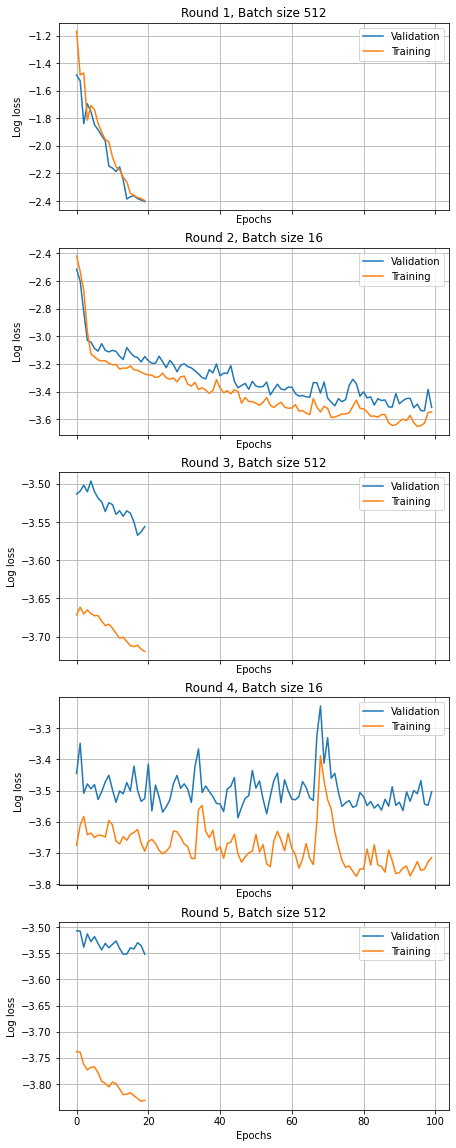

In [12]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(len(history), 1, figsize=(7, len(history)*4), sharex=True)

for i in range(len(history)):

  ax[i].set_title(titles[i])
  ax[i].plot(history[i].epoch, np.log(history[i].history['val_loss']), label='Validation')
  ax[i].plot(history[i].epoch, np.log(history[i].history['loss']), label='Training')
  ax[i].set_xlabel('Epochs')
  ax[i].set_ylabel('Log loss')
  ax[i].legend()
  ax[i].grid()


### Results

#### Encode the data

In [13]:
encoded_data=encoder.predict(qt).flatten()
encoded_data.shape

(506,)

#### Generate types

In [14]:
min_x, max_x, grid_n = -2, 2, 401
grid_x = np.linspace(min_x,max_x,grid_n)
decoded=decoder.predict(grid_x)
decoded.shape

(401, 14)

#### Plot type distribution

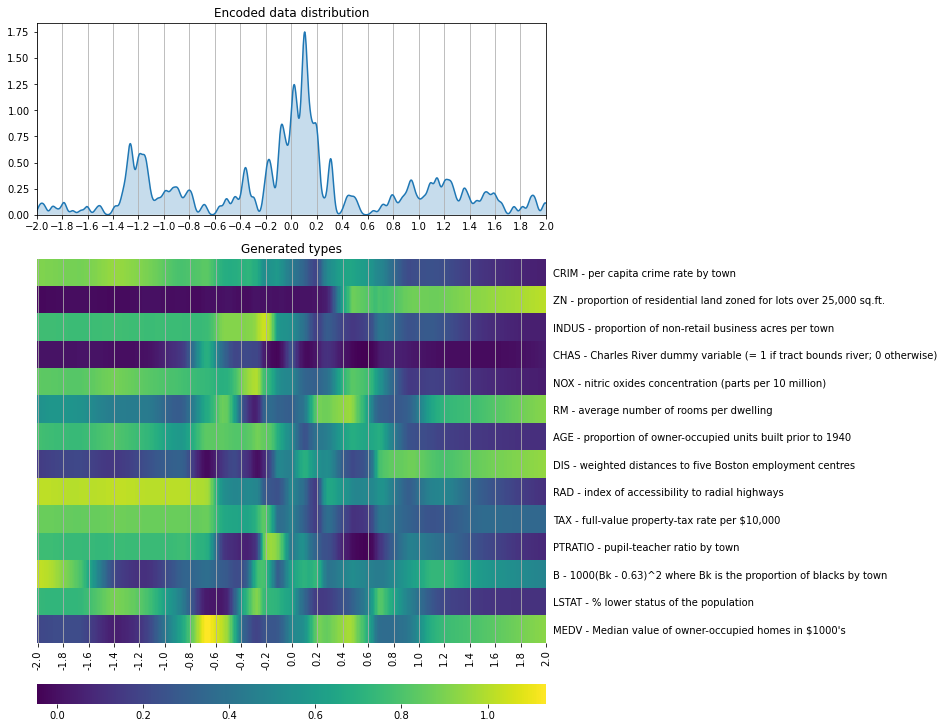

In [15]:
import seaborn as sns

fig = plt.figure(figsize=(13,10),constrained_layout=True)
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1:,:])

n_grid_lines=21
grid_lines = np.linspace(min_x,max_x,n_grid_lines)

ax1.set_title('Encoded data distribution')
sns.kdeplot(encoded_data,bw=0.02, shade = True, ax=ax1, gridsize=2000)
ax1.set_xticks( grid_lines )
ax1.set_xlim(min_x,max_x)
ax1.grid(axis='x')

ax2.set_title('Generated types')

sns.heatmap(decoded.T,cmap='viridis',ax=ax2, cbar_kws={'orientation':'horizontal'})
ax2.set_xticks(np.linspace(1,grid_n,n_grid_lines))
ax2.set_xticklabels(['{:.2}'.format(a) for a in grid_lines ])
ax2.set_yticklabels(labels)
ax2.tick_params(axis='y',labelright=True, labelleft=False, 
                left=False, labelrotation=0)
ax2.grid(axis='x')


## American Time Use

In [0]:
K.clear_session()

### Data

In [16]:
df=pd.read_csv("https://github.com/yaniv256/VAEs-in-Economics/blob/master/Data/Timeuse/time_shares_only_2013.csv?raw=true")
df

,Sleeping,Television_and_movies__not_religious_,Work__main_job,Eating_and_drinking,Socializing_and_communicating_with_others,Washing__dressing_and_grooming_oneself,Food_and_drink_preparation_,Interior_cleaning,Reading_for_personal_interest,Relaxing__thinking_,Shopping__except_groceries__food_and_gas,Travel_related_to_working,Playing_games,Laundry,Computer_use_for_leisure__exc__Games_,Lawn__garden__and_houseplant_care,Insufficient_detail_in_verbatim,Physical_care_for_hh_children,Attending_religious_services,Playing_with_hh_children__not_sports,Kitchen_and_food_clean_up,Grocery_shopping,Travel_related_to_eating_and_drinking,Research_homework_for_class_for_degree__certification__or_licensure,Travel_related_to_shopping__ex_groceries__food__and_gas,Household___personal_organization_and_planning,Taking_class_for_degree__certification__or_licensure,Travel_related_to_socializing_and_communicating,Health_related_self_care,Attending_or_hosting_parties_receptions_ceremonies,Work__other_job_s_,Gap_can_t_remember,Travel_related_to_caring_for___helping_hh_children,Sleeplessness,Travel_related_to_grocery_shopping,Walking,Care_for_animals_and_pets__not_veterinary_care_,Walking___exercising___playing_with_animals,Participation_in_religious_practices,Interior_arrangement__decoration____repairs,...,Travel_rel__to_socializing__relaxing____leisure__n_e_c__,Waiting_associated_w_banking_financial_services,Waiting_associated_w_admin__activities__education_,Travel_related_to_using_lawn_and_garden_services,Travel_related_to_nonhh_children_s_education,Waiting_associated_with_work_related_activities,Using_interior_cleaning_services_,Waiting_assoc__w_attending_hosting_social_events,Watching_rugby,Watching_skiing__ice_skating__snowboarding,Travel_related_to_personal_care__n_e_c__,Travel_related_to_education__n_e_c__,Travel_related_to_using_household_services__n_e_c__,Travel_related_to_work__n_e_c__,Travel_rel__to_religious_spiritual_activities__n_e_c__,Waiting_associated_w_purchasing_selling_real_estate,Waiting_associated_with_socializing__n_e_c__,Travel_related_to_consumer_purchases__n_e_c__,Security_procedures_related_to_work,Using_pet_services__n_e_c__,Telephone_calls_to_from_paid_child_or_adult_care_providers,Travel_related_to_using_legal_services,Lawn_and_garden__n_e_c___,Waiting_associated_with_research_homework,Waiting_associated_with_pet_services,Waiting_associated_with_other_income_generating_activities,Using_vehicle_maint____repair_svcs__n_e_c__,Housework__n_e_c___,Using_lawn_and_garden_services__n_e_c__,Security_procedures_rel__to_govt_svcs_civic_obligations__n_e_c__,Activities_related_to_nonhh_child_s_educ___n_e_c__,Waiting_associated_with_job_search_or_interview,Work_and_work_related_activities__n_e_c__,Government_services__n_e_c__,Public_health___safety_activities__n_e_c__,Travel_related_to_household_activities__n_e_c__,Travel_rel__to_govt_svcs___civic_obligations__n_e_c__,Food___drink_prep__presentation____clean_up__n_e_c___,Telephone_calls__n_e_c__,Public_health_activities
0,540,330,0,35,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,455,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,580,95,0,75,0,35,60,25,15,0,0,0,0,0,50,0,0,80,0,309,20,60,0,0,0,5,0,0,0,0,0,0,0,0,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,450,60,0,170,0,90,105,0,20,0,0,0,0,0,0,0,0,0,0,0,15,15,0,0,0,0,0,0,0,0,0,0,0,0,40,0,145,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,450,65,680,70,0,30,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,570,90,0,120,0,0,60,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,510,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [17]:
qt_trans = QuantileTransformer(n_quantiles=1000, random_state=0)
qt = pd.DataFrame(qt_trans.fit_transform(df))
qt.columns = df.columns
qt

,Sleeping,Television_and_movies__not_religious_,Work__main_job,Eating_and_drinking,Socializing_and_communicating_with_others,Washing__dressing_and_grooming_oneself,Food_and_drink_preparation_,Interior_cleaning,Reading_for_personal_interest,Relaxing__thinking_,Shopping__except_groceries__food_and_gas,Travel_related_to_working,Playing_games,Laundry,Computer_use_for_leisure__exc__Games_,Lawn__garden__and_houseplant_care,Insufficient_detail_in_verbatim,Physical_care_for_hh_children,Attending_religious_services,Playing_with_hh_children__not_sports,Kitchen_and_food_clean_up,Grocery_shopping,Travel_related_to_eating_and_drinking,Research_homework_for_class_for_degree__certification__or_licensure,Travel_related_to_shopping__ex_groceries__food__and_gas,Household___personal_organization_and_planning,Taking_class_for_degree__certification__or_licensure,Travel_related_to_socializing_and_communicating,Health_related_self_care,Attending_or_hosting_parties_receptions_ceremonies,Work__other_job_s_,Gap_can_t_remember,Travel_related_to_caring_for___helping_hh_children,Sleeplessness,Travel_related_to_grocery_shopping,Walking,Care_for_animals_and_pets__not_veterinary_care_,Walking___exercising___playing_with_animals,Participation_in_religious_practices,Interior_arrangement__decoration____repairs,...,Travel_rel__to_socializing__relaxing____leisure__n_e_c__,Waiting_associated_w_banking_financial_services,Waiting_associated_w_admin__activities__education_,Travel_related_to_using_lawn_and_garden_services,Travel_related_to_nonhh_children_s_education,Waiting_associated_with_work_related_activities,Using_interior_cleaning_services_,Waiting_assoc__w_attending_hosting_social_events,Watching_rugby,Watching_skiing__ice_skating__snowboarding,Travel_related_to_personal_care__n_e_c__,Travel_related_to_education__n_e_c__,Travel_related_to_using_household_services__n_e_c__,Travel_related_to_work__n_e_c__,Travel_rel__to_religious_spiritual_activities__n_e_c__,Waiting_associated_w_purchasing_selling_real_estate,Waiting_associated_with_socializing__n_e_c__,Travel_related_to_consumer_purchases__n_e_c__,Security_procedures_related_to_work,Using_pet_services__n_e_c__,Telephone_calls_to_from_paid_child_or_adult_care_providers,Travel_related_to_using_legal_services,Lawn_and_garden__n_e_c___,Waiting_associated_with_research_homework,Waiting_associated_with_pet_services,Waiting_associated_with_other_income_generating_activities,Using_vehicle_maint____repair_svcs__n_e_c__,Housework__n_e_c___,Using_lawn_and_garden_services__n_e_c__,Security_procedures_rel__to_govt_svcs_civic_obligations__n_e_c__,Activities_related_to_nonhh_child_s_educ___n_e_c__,Waiting_associated_with_job_search_or_interview,Work_and_work_related_activities__n_e_c__,Government_services__n_e_c__,Public_health___safety_activities__n_e_c__,Travel_related_to_household_activities__n_e_c__,Travel_rel__to_govt_svcs___civic_obligations__n_e_c__,Food___drink_prep__presentation____clean_up__n_e_c___,Telephone_calls__n_e_c__,Public_health_activities
0,0.571572,0.831832,0.000000,0.304805,0.000000,0.311311,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.997387,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.693193,0.400901,0.000000,0.646146,0.000000,0.508008,0.825325,0.782282,0.791792,0.000000,0.0,0.000000,0.000000,0.000000,0.919920,0.0,0.000000,0.961962,0.0,0.995862,0.851852,0.958458,0.000000,0.000000,0.0,0.871371,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.877878,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.262262,0.304304,0.000000,0.958959,0.000000,0.903403,0.937437,0.000000,

In [0]:
from sklearn.model_selection import train_test_split 
x_train, x_test = train_test_split(qt, test_size=0.33, random_state=42)

### Network

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

def make_vae(input_shape):

  latent_dim = 1  
  dense_width = 1024

  input_x = keras.Input(shape=input_shape)

  x = layers.Dense(dense_width, activation='relu')(input_x)
  x = layers.Dense(dense_width, activation='relu')(x)
  x = layers.Dense(dense_width, activation='relu')(x)

  z_mean = layers.Dense(latent_dim)(x)
  z_log_var = layers.Dense(latent_dim)(x)

  encoder = Model(input_x, z_mean)

  def sampling(args):
      z_mean, z_log_var = args
      epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                                mean=0., stddev=1.)
      return z_mean + K.exp(z_log_var) * epsilon

  z = layers.Lambda(sampling)([z_mean, z_log_var])

  # This is the input where we will feed `z`.
  decoder_input = layers.Input(K.int_shape(z)[1:])

  # Upsample to the correct number of units
  x = layers.Dense(dense_width,activation='relu')(decoder_input)
  x = layers.Dense(dense_width,activation='relu')(x)
  x = layers.Dense(dense_width,activation='relu')(x)

  x = layers.Dense(input_shape[0])(x)

  # This is our decoder model.
  decoder = Model(decoder_input, x)

  # We then apply it to `z` to recover the decoded `z`.
  z_decoded = decoder(z)

  class CustomVariationalLayer(keras.layers.Layer):

      def vae_loss(self, x, z_decoded):
          xent_loss = keras.metrics.mse(x, z_decoded)
          kl_loss = -5e-4 * K.mean(
              1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
          return K.mean(xent_loss + kl_loss)

      def call(self, inputs):
          x = inputs[0]
          z_decoded = inputs[1]
          loss = self.vae_loss(x, z_decoded)
          self.add_loss(loss, inputs=inputs)
          # We don't use this output.
          return x

  # We call our custom layer on the input and the decoded output,
  # to obtain the final model output.
  y = CustomVariationalLayer()([input_x, z_decoded])

  vae = Model(input_x, y)
  vae.encoder = encoder
  vae.decoder = decoder

  return vae

### Training

In [20]:
vae = make_vae(input_shape=(x_train.shape[1],))

vae.compile(optimizer='adam', loss=None)

n_batch_sizes=9

history = ['']*n_batch_sizes
titles  = ['']*n_batch_sizes

# Train the VAE on boston housing data

for i in range(n_batch_sizes):

  # Alternate between a few epochs with large batch size (realiable decrease in 
  # loss but weak and overfitting) and a few epochs with small batch size
  # (strong and non-overfitting but could increase loss)
  batch_size = 4096*(1-(i%2)) + 64*(i%2)
  epochs = 50*(1-(i%2)) + 50*(i%2)

  print('Batch size:', batch_size)
  titles[i] = 'Round {}, Batch size {}'.format(i+1, batch_size)

  history[i] = vae.fit(x=x_train, y=None,
                       shuffle=True,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(x_test, None))

Batch size: 4096
Train on 7627 samples, validate on 3758 samples
Epoch 1/50
7627/7627 [==============================] - 1s 75us/sample - loss: 0.0204 - val_loss: 0.0192
Epoch 2/50
7627/7627 [==============================] - 0s 13us/sample - loss: 0.0186 - val_loss: 0.0179
Epoch 3/50
7627/7627 [==============================] - 0s 12us/sample - loss: 0.0176 - val_loss: 0.0171
Epoch 4/50
7627/7627 [==============================] - 0s 12us/sample - loss: 0.0169 - val_loss: 0.0169
Epoch 5/50
7627/7627 [==============================] - 0s 12us/sample - loss: 0.0166 - val_loss: 0.0166
Epoch 6/50
7627/7627 [==============================] - 0s 12us/sample - loss: 0.0163 - val_loss: 0.0162
Epoch 7/50
7627/7627 [==============================] - 0s 12us/sample - loss: 0.0160 - val_loss: 0.0161
Epoch 8/50
7627/7627 [==============================] - 0s 12us/sample - loss: 0.0159 - val_loss: 0.0161
Epoch 9/50
7627/7627 [==============================] - 0s 12us/sample - loss: 0.0159 - val_los

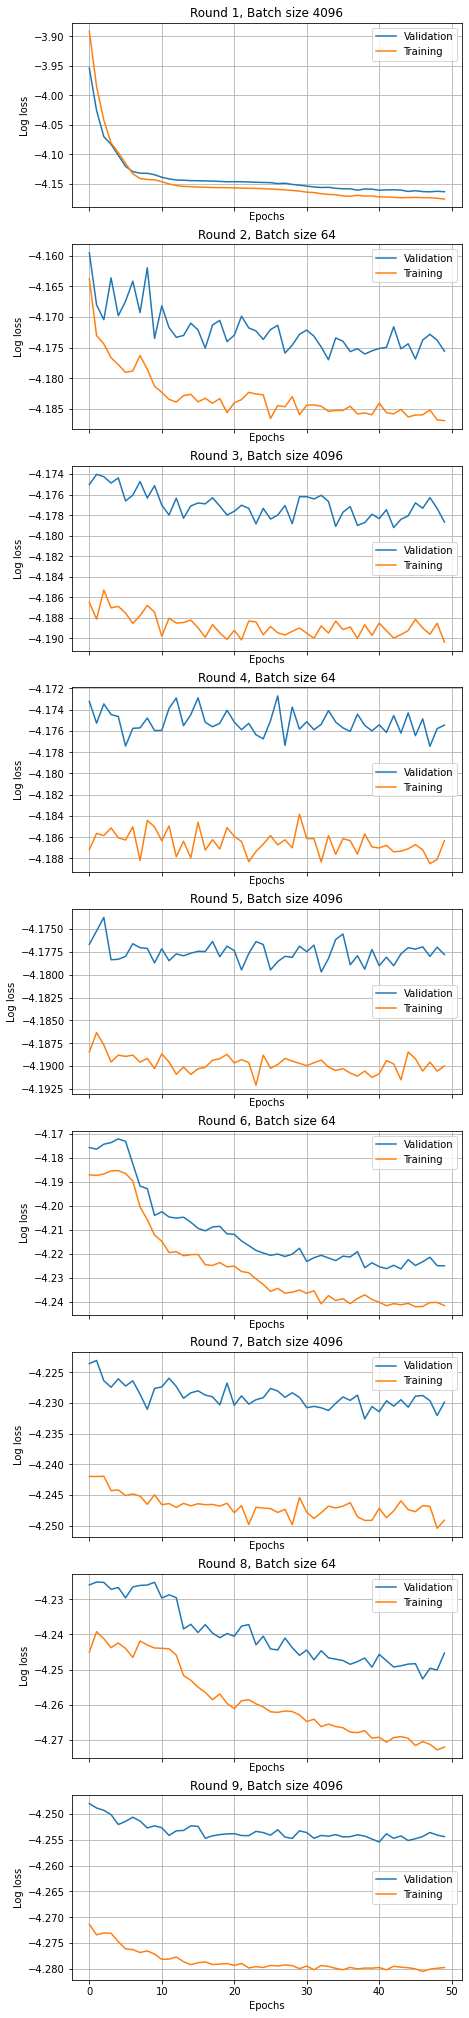

In [21]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(len(history), 1, figsize=(7, len(history)*4), sharex=True)

for i in range(len(history)):

  ax[i].set_title(titles[i])
  ax[i].plot(history[i].epoch, np.log(history[i].history['val_loss']), label='Validation')
  ax[i].plot(history[i].epoch, np.log(history[i].history['loss']), label='Training')
  ax[i].set_xlabel('Epochs')
  ax[i].set_ylabel('Log loss')
  ax[i].legend()
  ax[i].grid()

### Results

#### Time use distribution

In [23]:
encoded_data=vae.encoder.predict(qt).flatten()
encoded_data.shape

(11385,)

In [25]:
min_x, max_x, grid_n = -2, 2, 401
grid_x = np.linspace(min_x,max_x,grid_n)
decoded=vae.decoder.predict(grid_x)
decoded.shape

(401, 389)

In [0]:
import seaborn as sns

def plot_type_dist(encoded_data, grid_x, decoded, vertical_n, type_labels):

  fig = plt.figure(figsize=(13,vertical_n*2.5),constrained_layout=True)
  gs = fig.add_gridspec(vertical_n, 1)
  ax1 = fig.add_subplot(gs[0,:])
  ax2 = fig.add_subplot(gs[1:,:])

  n_grid_lines=21
  min_x, max_x, grid_n = grid_x[0], grid_x[-1], len(grid_x)
  grid_lines = np.linspace(min_x,max_x,n_grid_lines)

  ax1.set_title('Encoded data distribution')
  sns.kdeplot(encoded_data,bw=0.02, shade = True, ax=ax1, gridsize=2000)
  ax1.set_xticks( grid_lines )
  ax1.set_xlim(min_x,max_x)
  ax1.grid(axis='x')

  ax2.set_title('Generated types')

  sns.heatmap(decoded.T,cmap='viridis',ax=ax2, cbar_kws={'orientation':'horizontal'})
  ax2.set_xticks(np.linspace(1,grid_n,n_grid_lines))
  ax2.set_xticklabels(['{:.2}'.format(a) for a in grid_lines ])
  ax2.set_yticklabels(type_labels)
  ax2.tick_params(axis='y',labelright=True, labelleft=False, 
                  left=False, labelrotation=0)
  ax2.grid(axis='x')

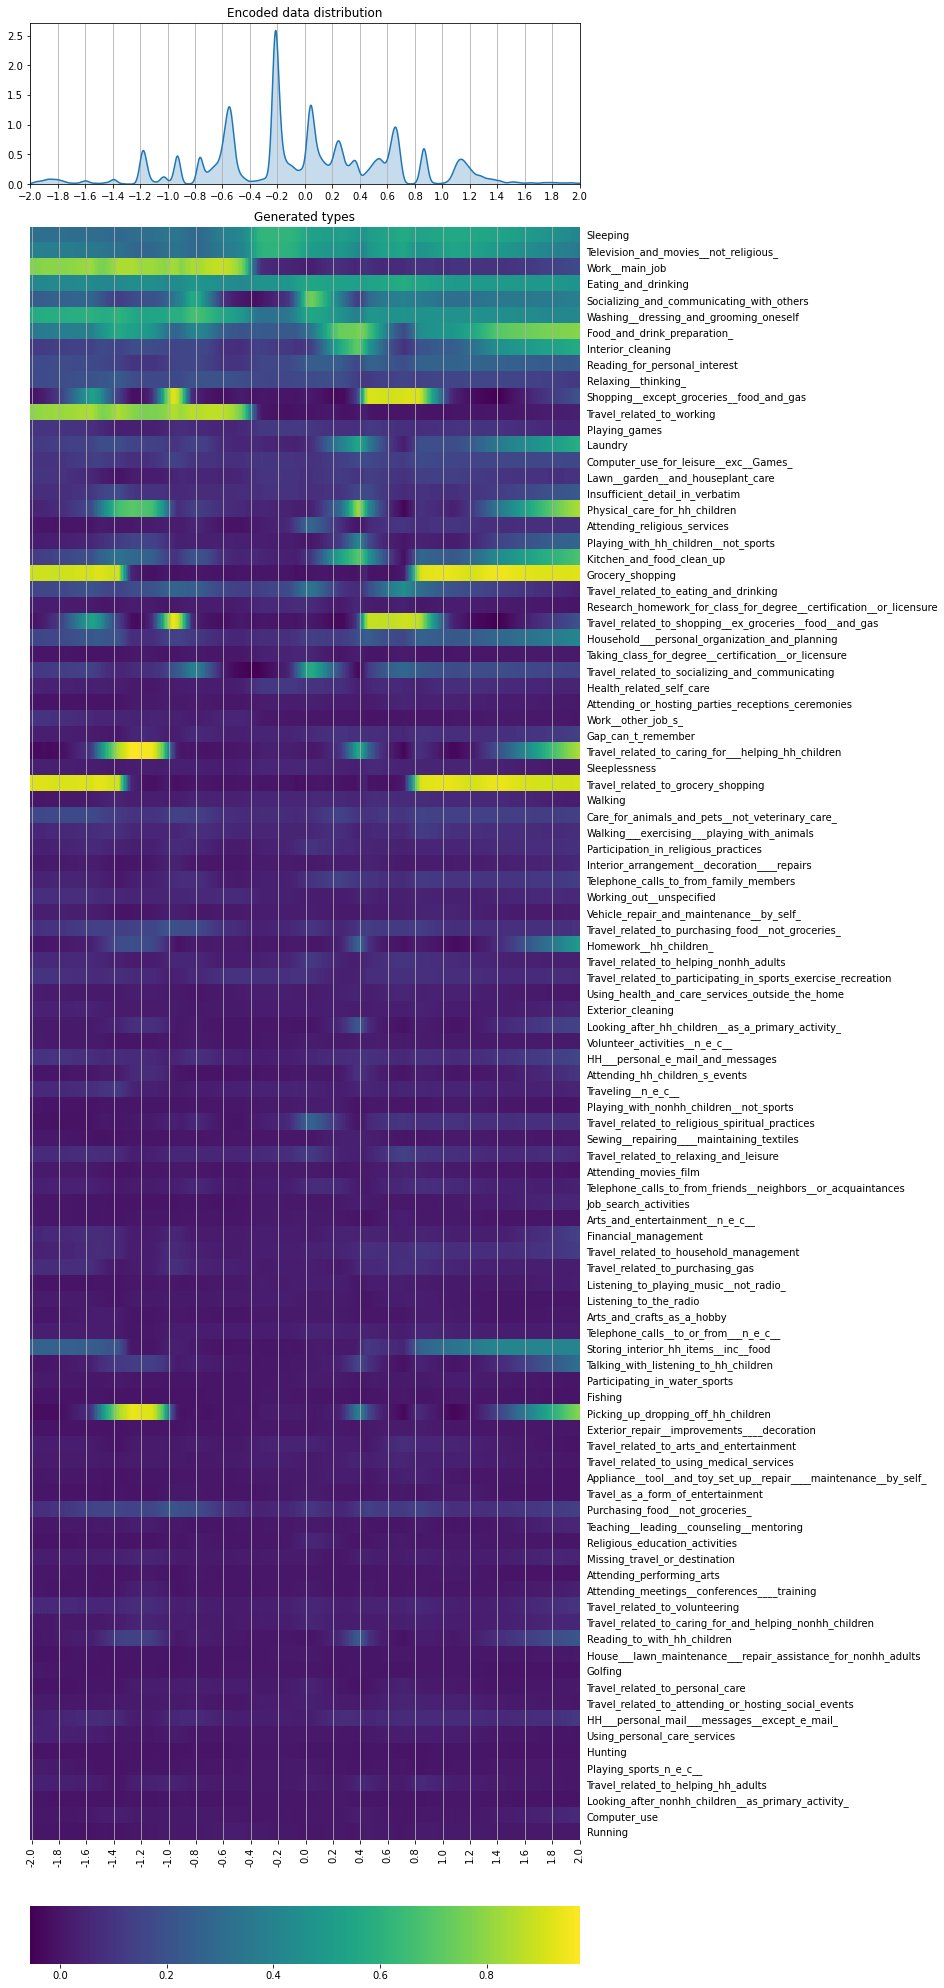

In [80]:
plot_type_dist(encoded_data, grid_x, decoded[:,:100], 
               vertical_n=11, type_labels=qt.columns[:100])

#### Time use by gender

In [75]:
df = pd.read_csv('https://raw.githubusercontent.com/yaniv256/VAEs-in-Economics/master/Data/Timeuse/atussum_2013/atussum_2013.dat')
df

,tucaseid,TUFINLWGT,TRYHHCHILD,TEAGE,TESEX,PEEDUCA,PTDTRACE,PEHSPNON,GTMETSTA,TELFS,TEMJOT,TRDPFTPT,TESCHENR,TESCHLVL,TRSPPRES,TESPEMPNOT,TRERNWA,TRCHILDNUM,TRSPFTPT,TEHRUSLT,TUDIARYDAY,TRHOLIDAY,TRTEC,TRTHH,t010101,t010102,t010201,t010299,t010301,t010399,t010401,t020101,t020102,t020103,t020104,t020199,t020201,t020202,t020203,t020299,...,t180704,t180799,t180801,t180802,t180803,t180804,t180805,t180806,t180807,t180899,t180901,t180902,t180903,t180904,t180905,t180999,t181001,t181002,t181099,t181101,t181201,t181202,t181203,t181204,t181205,t181299,t181301,t181302,t181401,t181499,t181501,t181599,t181601,t181801,t189999,t500101,t500103,t500105,t500106,t500107
0,20130101130004,1.189991e+07,12,22,2,40,8,2,1,5,-1,-1,1,2,3,-1,-1,3,-1,-1,1,0,-1,365,540,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20130101130112,4.447638e+06,1,39,1,43,1,2,1,1,2,1,2,-1,1,1,173076,1,2,40,1,0,-1,296,580,0,35,0,0,0,0,25,0,0,0,0,60,0,20,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,20130101130123,1.037706e+07,-1,47,2,40,1,2,1,4,-1,-1,2,-1,1,1,-1,0,3,-1,2,0,-1,0,450,0,90,0,0,0,0,0,0,0,0,0,105,30,15,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0
3,20130101130611,7.731258e+06,-1,50,2,40,1,1,1,1,2,1,-1,-1,3,-1,86538,0,-1,-4,3,0,-1,0,450,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,20130101130616,4.725269e+06,-1,45,2,40,2,2,1,1,1,2,1,2,3,-1,23000,0,-1,21,2,0,-1,0,570,0,0,0,0,0,0,0,30,0,0,0,60,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11380,20131212132458,4.469644e+06,-1,85,2,44,1,2,1,5,-1,-1,-1,-1,3,-1,-1,0,-1,-1,2,0,-1,0,450,0,15,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11381,20131212132462,4.103677e+06,-1,60,1,39,1,1,1,1,2,1,-1,-1,1,2,61538,0,-1,40,1,0,-1,0,455,0,75,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11382,20131212132469,2.355797e+07,9,43,1,39,1,1,1,1,2,1,2,-1,1,1,80000,2,1,40,5,0,-1,77,645,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11383,20131212132475,2.045005e+07,16,48,1,39,1,2,1,1,2,1,2,-1,1,1,66000,1,1,40,4,1,-1,0,510,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,0,0,0,0


In [76]:
Female = (df['TESEX'] == 2)
encoded_data[Female].shape , encoded_data[Female == False].shape

((6303,), (5082,))

In [0]:
def plot_type_dist_list(encoded_data_list, grid_x, decoded, 
                        type_labels, vertical_n, dist_labels):

  fig = plt.figure(figsize=(13,vertical_n*2.5),constrained_layout=True)
  gs = fig.add_gridspec(vertical_n, 1)
  ax1 = fig.add_subplot(gs[0,:])
  ax2 = fig.add_subplot(gs[1:,:])

  n_grid_lines=21
  min_x, max_x, grid_n = grid_x[0], grid_x[-1], len(grid_x)
  grid_lines = np.linspace(min_x,max_x,n_grid_lines)

  ax1.set_title('Encoded data distribution')
  for i in range(len(encoded_data_list)):
    sns.kdeplot(encoded_data_list[i],bw=0.02, shade = True, 
                ax=ax1, gridsize=2000, label=dist_labels[i])
  ax1.set_xticks( grid_lines )
  ax1.set_xlim(min_x,max_x)
  ax1.grid(axis='x')

  ax2.set_title('Generated types')

  sns.heatmap(decoded.T,cmap='viridis',ax=ax2, cbar_kws={'orientation':'horizontal'})
  ax2.set_xticks(np.linspace(1,grid_n,n_grid_lines))
  ax2.set_xticklabels(['{:.2}'.format(a) for a in grid_lines ])
  ax2.set_yticklabels(type_labels)
  ax2.tick_params(axis='y',labelright=True, labelleft=False, 
                  left=False, labelrotation=0)
  ax2.grid(axis='x')

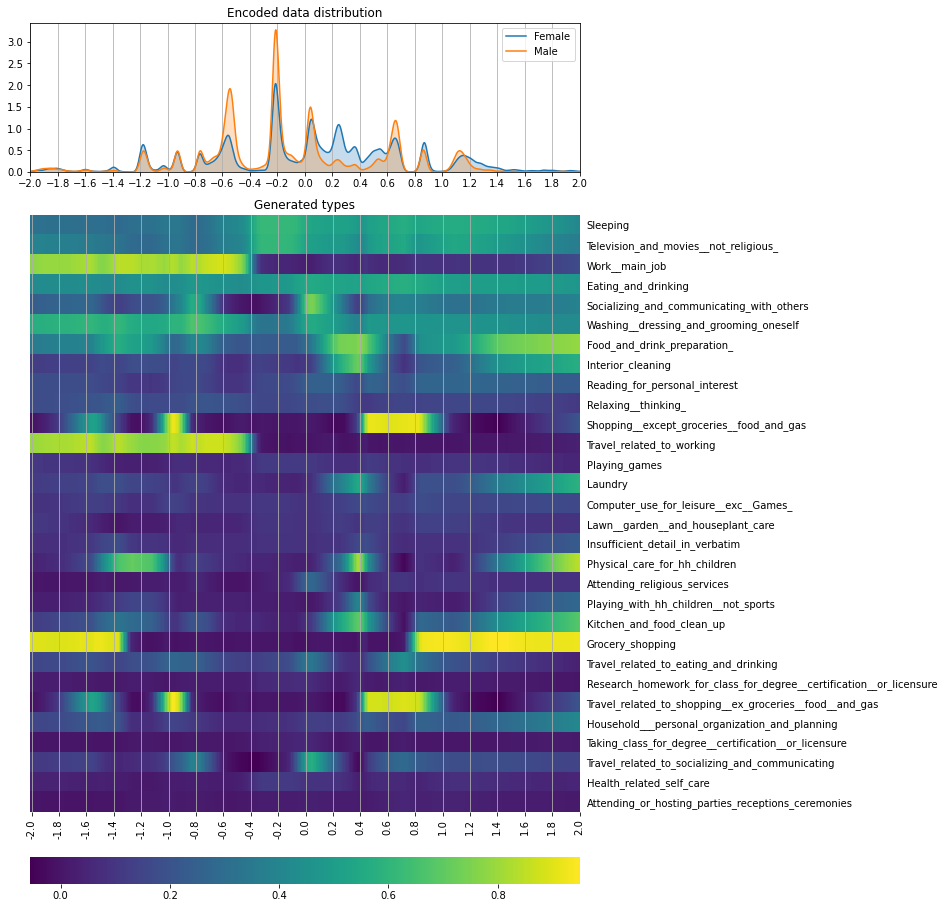

In [82]:
plot_type_dist_list([encoded_data[Female], encoded_data[Female == False]], 
                    grid_x, decoded[:,:30], 
                    type_labels=qt.columns[:30], vertical_n=5,
                    dist_labels = ['Female', 'Male'])

#### Time use by labor force status

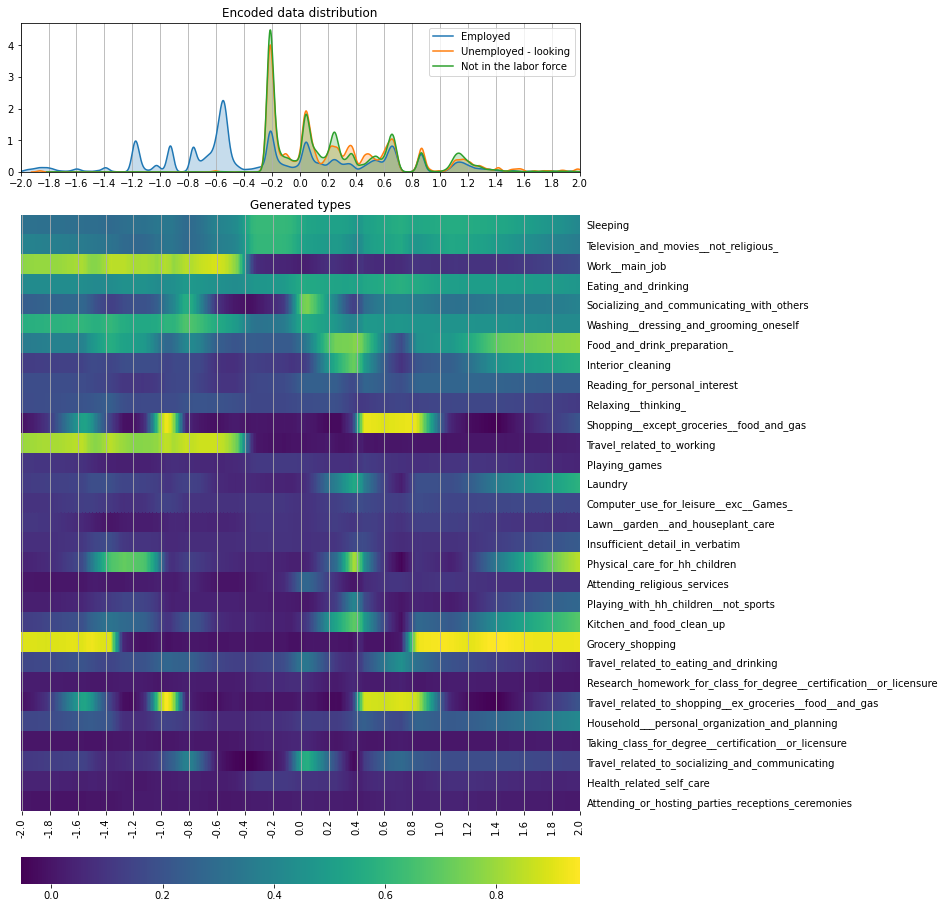

In [85]:
Employed = df['TELFS'] == 1
UnemployedLooking = df['TELFS'] == 4
NotInTheLaborForce = df['TELFS'] == 5

plot_type_dist_list([encoded_data[Employed], 
                     encoded_data[UnemployedLooking],
                     encoded_data[NotInTheLaborForce] 
                     ], 
                    grid_x, decoded[:,:30], 
                    type_labels=qt.columns[:30], vertical_n=5,
                    dist_labels = ['Employed', 
                                   'Unemployed - looking', 
                                   'Not in the labor force'])

#### Time use by number of children

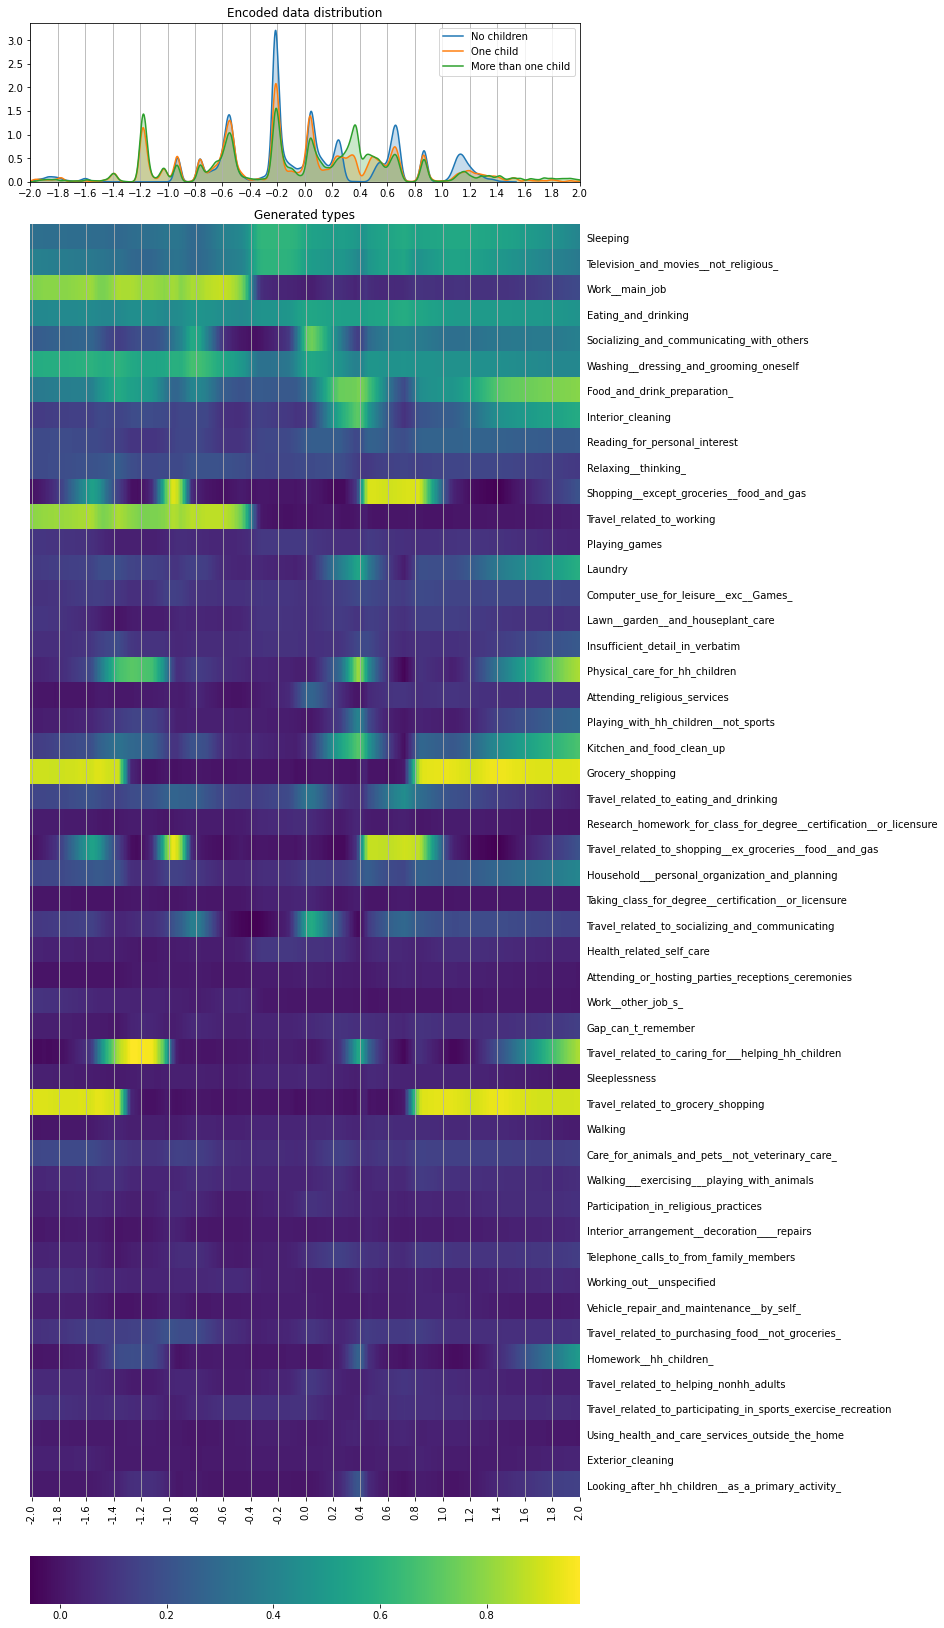

In [87]:
plot_type_dist_list([encoded_data[df['TRCHILDNUM'] == 0 ], 
                     encoded_data[df['TRCHILDNUM'] == 1],
                     encoded_data[df['TRCHILDNUM'] > 1] 
                     ], 
                    grid_x, decoded[:,:50], 
                    type_labels=qt.columns[:50], vertical_n=9,
                    dist_labels = ['No children', 
                                   'One child', 
                                   'More than one child'])